# Discovery of the p53 targetome in MCF7 cells from RNA-seq data

## *Analysis of differential gene expression*

The gene counts file generated from the previous analysis (mapping and counting) will be used. This gene counts file shows the number of sequence reads that was obtained from each gene. Thus, genes with higher sequence reads are asssumed to have higher level of expression. The aim of differential gene expression analysis is to determine if there is significant difference in the expression level of genes. 

In [2]:
# load necessary packages
library("DESeq2")
library(dplyr)
library(scales)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [3]:
getwd()

[1] "/mnt/storage/r0605462/jupyternotebooks"

In [4]:
# include path to the gene counts file
matrixFile = path.expand("/mnt/nfs/data/RNA-seq/MCF7/all.gene.counts")

In [5]:
# create a matrix of the gene counts file
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)

,NS1.bam,NS2.bam,S1.bam,S2.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,1
RP11-34P13.8,0,0,0,0
AL627309.1,37,42,83,62


In [6]:
# modify the column names and remove the .bam suffix
colnames(countData) <- c("NS1", "NS2", "S1", "S2")
head(countData)

,NS1,NS2,S1,S2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,1
RP11-34P13.8,0,0,0,0
AL627309.1,37,42,83,62


In [7]:
# create the conditions which are stimulated (S) vs non-stimulated(NS)
condition <- factor(c("NS", "NS", "S", "S"))
print(condition)

[1] NS NS S  S 
Levels: NS S


In [8]:
# create a data frame to be used in generating the DESEQ object
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
NS1,NS
NS2,NS
S1,S
S2,S


## *DESEQ2 object setup*

In [9]:
# Create a DESEQ2 object
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
# colData = a data frame with columns as the variables known about the samples (such as conditions)and rownames as unique sample names
# countData = a matrix of the actual gene count values

In [10]:
# Set the column names to be same as the treatments. we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

In [11]:
dds$condition

[1] NS NS S  S 
Levels: NS S

In [12]:
dim(dds)

[1] 41863     4

In [13]:
# filter out genes with no reads
keep_genes <- rowSums(counts(dds)) > 0
dds <- dds[keep_genes,]
dim(dds)

[1] 23731     4

## *Exploratory data analysis - count data quality control*

*Principal component analysis*

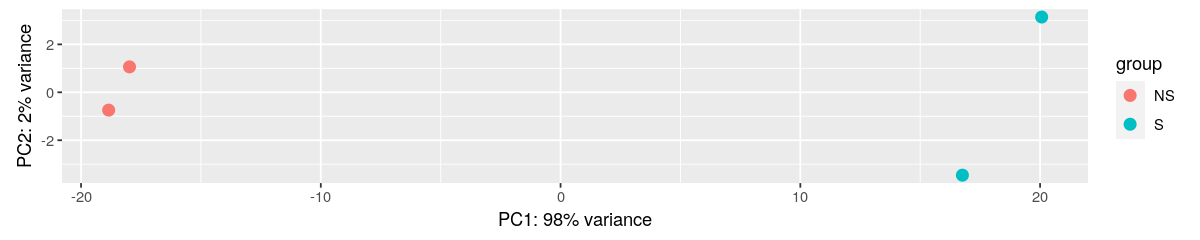

In [14]:

# Transform counts for data visualization
rld <- rlog(dds, blind=TRUE)
options(repr.plot.width=10, repr.plot.height=2)
plotPCA(rld, intgroup="condition")

PC1 explains 98% of the variance in gene expression in the cells by dividing the cells into two groups that correspond to the treatment on each cell.

*Scatter plot*

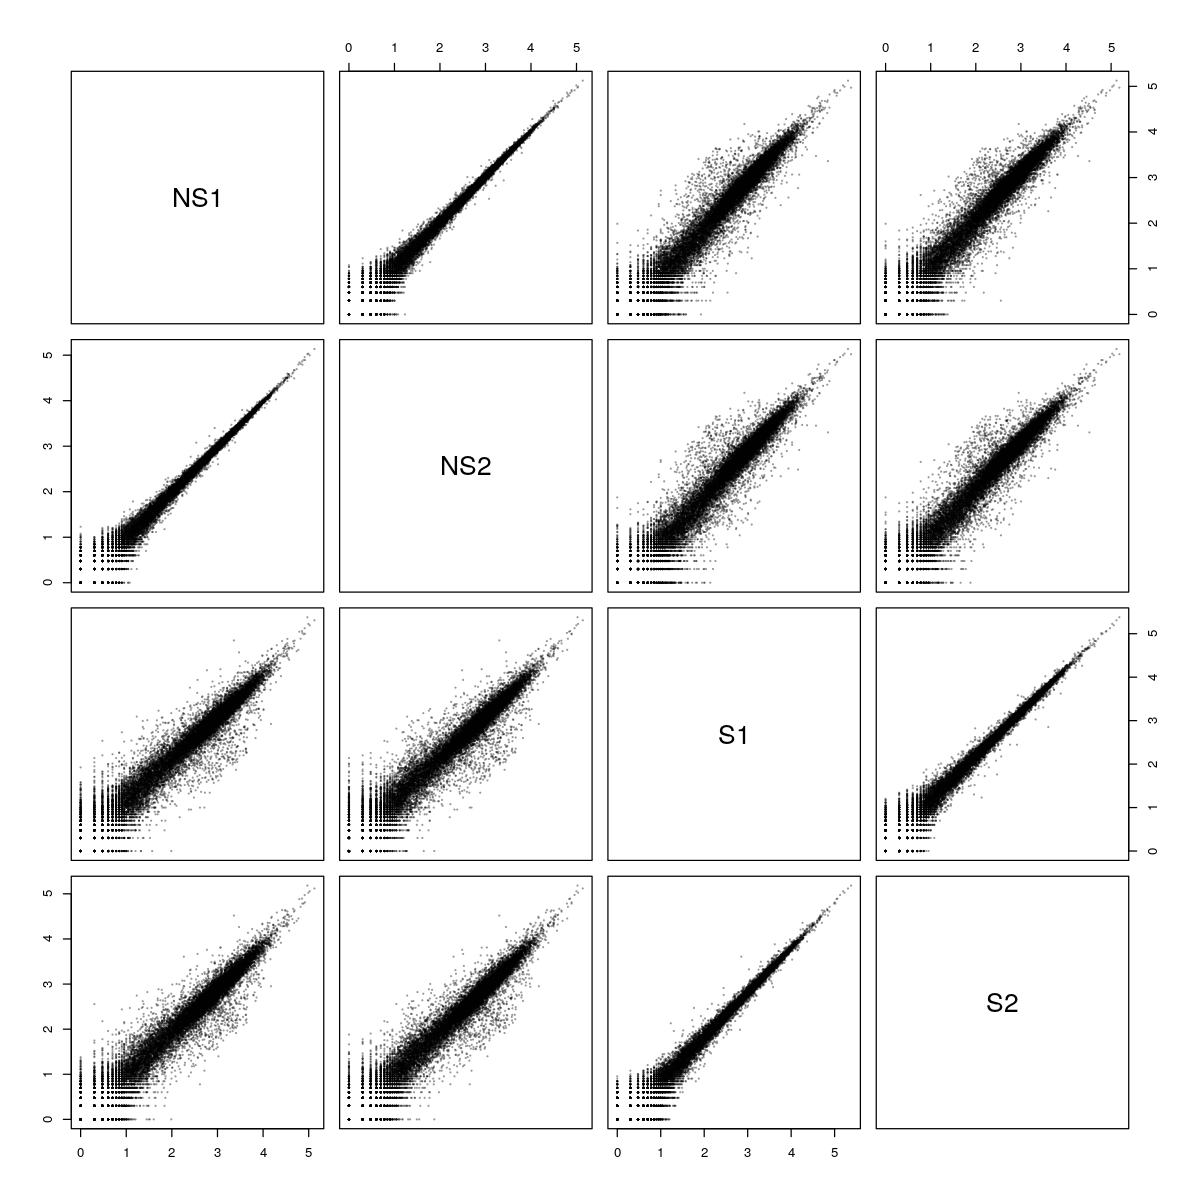

In [15]:
options(repr.plot.width=10, repr.plot.height=10)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

The scatterplot show strong positive correlation between cell samples that received similar treatment; for example the correlation between S1 and S2. Also, there is weak positive correlation between cells that did not receive the same treatment. For example, NS1 vs S1

*Hierarchical clustering*

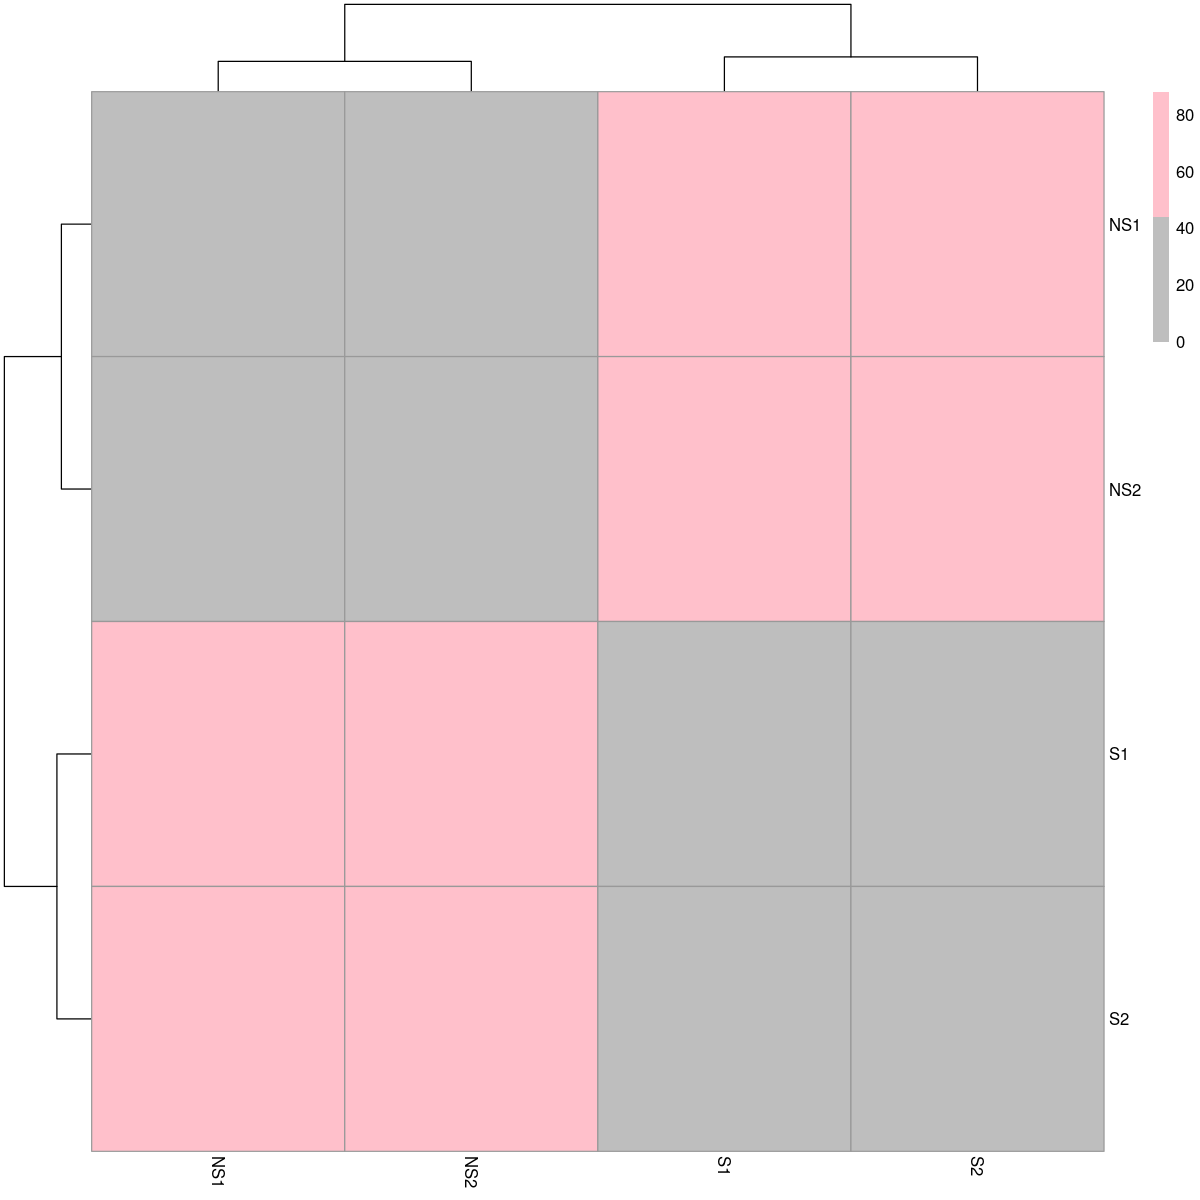

In [16]:

deseq2VST <- vst(dds)
sampleDists <- dist(t(assay(deseq2VST)))
sampleDistMatrix <- as.matrix(sampleDists)
colors <- c("grey", "pink")
pheatmap(sampleDistMatrix,clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         cluster_rows =T, cluster_cols = T,
         col = colors)

The result of the hierarchical clustering corresponds with the conditions being tested
whereby the cells having Nutlin-3a treatment cluster together

## *Differential expression analysis*

In [17]:
dE <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## *MA plot*

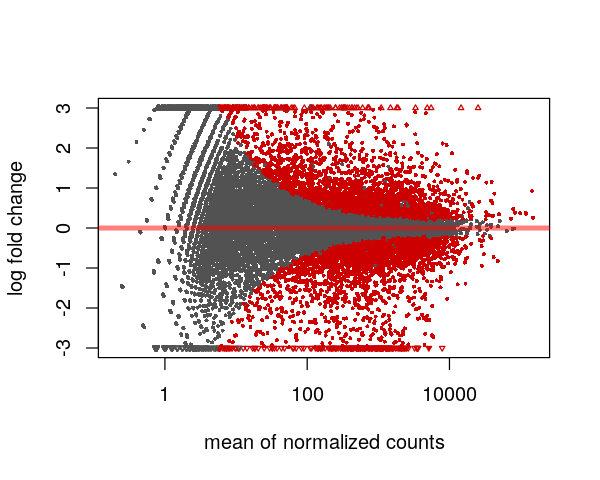

In [18]:
# The MA plot is used to visualize the significantly and differentially expressed genes which are shown in red
options(repr.plot.width=5, repr.plot.height=4)
plotMA(dE,ylim=c(-3,3))

In an MA plot, each data point represents a single gene. The data points (genes) above zero are upregulated and otherwise fpr the datapoints below zero. The significantly differentially expressed genes are colored in red.

## *Number of significantly expressed genes*

In [19]:
res <- results(dE)
res <- res[order(res$padj),]
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),] #select rows where padj is not NA and less than 0.05
nrow(res.sign) # number of significantly expressed genes


[1] 5552

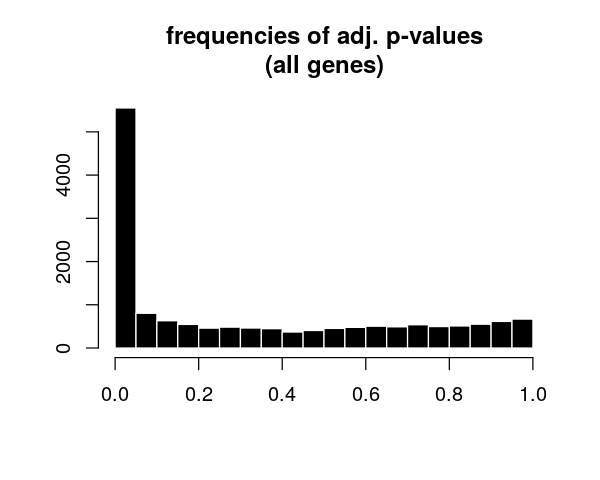

In [20]:
# Histogram showing the distribution of significant genes (p-adj < 0.05)
hist(res$padj, 
     col="black", border="white", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")

## *Manually check the expression of known genes*

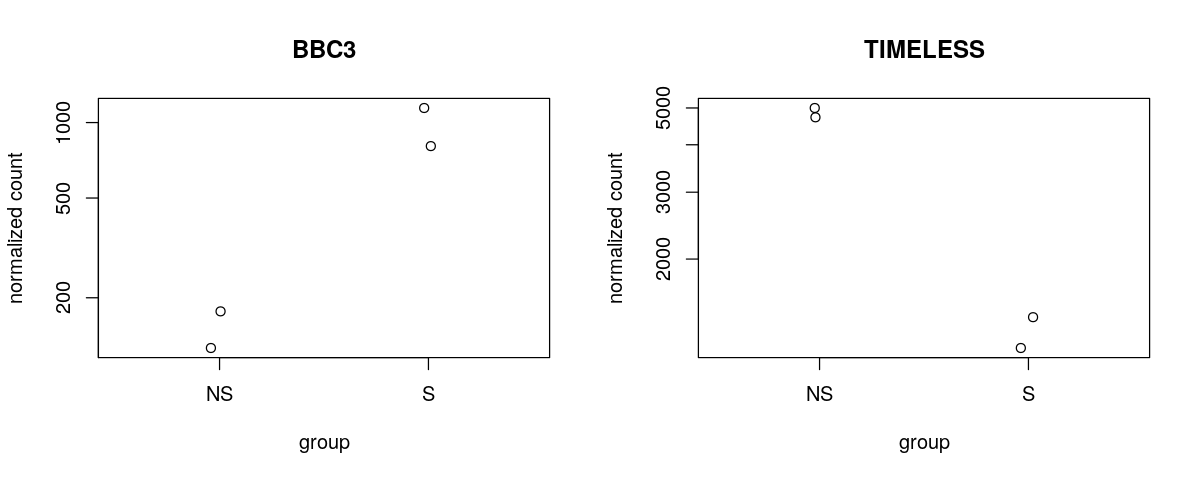

In [21]:
par(mfrow=c(1,2))
options(repr.plot.width=10, repr.plot.height=4)
plotCounts(dds, gene="BBC3", normalized = TRUE) # UPREGULATED BY p53 in stimulated cells
plotCounts(dds, gene="TIMELESS", normalized = TRUE) # DOWNREGULATED BY p53 in Stimulated cells

BBC3 which is a positive control gene is upregulated in the stimulated cells whereas TIMELESS which is a negative control gene is upregulated in the non-stimulated cells

*Save result*

In [22]:
setwd('/mnt/storage/r0605462/jupyternotebooks/RNASeq/')

In [23]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)

In [24]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.3.2               RColorBrewer_1.1-2         
 [3] pheatmap_1.0.12             scales_1.1.1               
 [5] dplyr_1.0.2                 DESeq2_1.24.0              
 [7] SummarizedExperiment_1.14.1 DelayedArray_0.10.0        
